In [33]:
from model import get_bellasio2019
from mxlpy import scan, Simulator, make_protocol
import pandas as pd
import mxlbricks.names as n
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.precision', 2)
get_bellasio2019().get_fluxes()

Ract_rate                  -6.31e-05
v_J_NADPH                   4.35e-01
v_J_ATP                     7.74e-01
v_gs                       -2.17e-03
rubisco_carboxylase         1.78e-02
rubisco_oxygenase           1.42e-02
glycine_decarboxylase       1.42e-02
r1p_kinase                  7.56e-02
v_pgareduction              2.56e-02
v_carbohydrate_synthesis    1.71e-02
v_rpp                      -2.17e-02
v_co2_hydration            -5.62e-01
v_RLight                    1.00e-03
v_NADPH                     8.54e-02
v_ATP                       1.36e-01
CO2 dissolution             7.00e-02
CO2 stomatal diffusion      4.69e-02
dtype: float64

In [3]:
get_bellasio2019().get_derived_parameters()

{'Et': Derived(
   fn=<function _Et>,
   args=['vmax_rubisco_carboxylase', 'kcat_rubisco_carboxylase', 'V_m']
 ),
 'O2 (dissolved)': Derived(fn=<function div>, args=['p_o2', 'Kh_o2']),
 'I2,0': Derived(fn=<function _i20>, args=['PPFD', 's']),
 'I1,0': Derived(fn=<function _i10>, args=['I2,0', 'Y(II)_LL', 'Y(I)_LL'])}

## Figure 3

In [4]:
fig3_res = scan.steady_state(
    get_bellasio2019(),
    to_scan=pd.DataFrame({n.pfd(): [50, 75, 100, 150, 200, 500, 1000, 1500]})
)

  0%|          | 0/8 [00:00<?, ?it/s]

[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1750742389890/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 100.943671580398 and h = 0.936535165729798, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1750742389890/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 105.301991655923 and h = 1.51782623249105, the corrector convergence test failed repeatedly or with |h| = hmin.
 12%|█▎        | 1/8 [00:00<00:01,  3.82it/s][ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1750742389890/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 99.1554191957013 and h = 1.01147666615581, the corrector convergence test failed repeatedly or with |h| = hmin.
[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1750742389890/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 93.1451551

In [5]:
fig3_res.variables

,CO2 (dissolved),HCO3,RUBP,3PGA,DHAP,ATP,NADPH,RU5P,Ract,J_NADPH,...,I1,f_cyc,I2,Y(II),J2,J1,f_pseudocyc,J_NADPH_steady,J_ATP_steady,gs_steady
PPFD,,,,,,,,,,,,,,,,,,,,,
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.48,0.0,21.50,NaN,NaN,NaN,NaN,NaN,NaN,0.01
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.22,0.0,32.25,NaN,NaN,NaN,NaN,NaN,NaN,0.01
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.96,0.0,43.00,NaN,NaN,NaN,NaN,NaN,NaN,0.01
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.44,0.0,64.50,NaN,NaN,NaN,NaN,NaN,NaN,0.01
200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.92,0.0,86.00,NaN,NaN,NaN,NaN,NaN,NaN,0.01
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,154.80,0.0,215.00,NaN,NaN,NaN,NaN,NaN,NaN,0.01
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,309.60,0.0,430.00,NaN,NaN,NaN,NaN,NaN,NaN,0.01
1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,464.40,0.0,645.00,NaN,NaN,NaN,NaN,NaN,NaN,0.01


TypeError: 'SteadyStateScan' object is not subscriptable

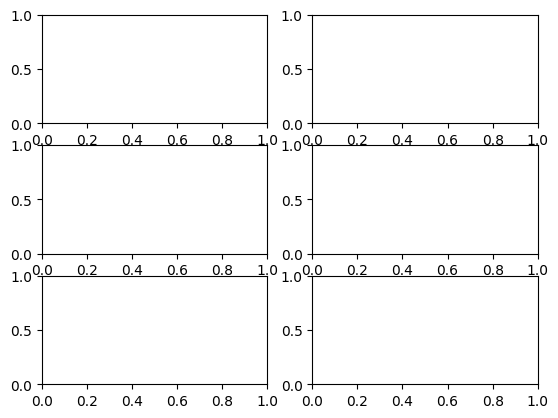

In [6]:
fig3, axs = plt.subplots(nrows=3, ncols=2)

axs[1, 0].plot(fig3_res["gs"])

## Figure 5

In [35]:
m = get_bellasio2019()

s = Simulator(m)

s.simulate_time_course(np.arange(0, 100, 5))

var, flux = s.get_result()

[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1750742389890/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 91.2067821959384 and h = 1.43111453953334, the corrector convergence test failed repeatedly or with |h| = hmin.


TypeError: cannot unpack non-iterable NoneType object

In [31]:
m = get_bellasio2019()

s = Simulator(m)

s.update_parameters({
    n.pfd(): 50,
    "Ca": 350,
    "chi_beta": 0.8,
    "tau0": -0.12,
    "Ki": 3600,
    "Kd": 1200
})

s.simulate(105)

var, flux = s.get_result()

var.iloc[-1].sort_values(ascending=True)

f_cyc                                0.00e+00
chi                                  0.00e+00
ADP                                  4.89e-03
CO2 (dissolved)                      7.19e-03
RU5P                                 1.16e-02
Y(II)                                5.49e-02
NADP                                 6.01e-02
HCO3                                 8.04e-02
km_rubisco_carboxylase_RUBP_extra    8.14e-02
J_NADPH                              2.16e-01
J_NADPH_steady                       2.16e-01
Ract_eq                              2.45e-01
gs                                   3.39e-01
NADPH                                4.40e-01
gs_steady                            4.63e-01
f_pseudocyc                          6.34e-01
J_ATP                                6.68e-01
f_rubp                               8.32e-01
J_ATP_steady                         8.85e-01
Ract                                 9.37e-01
J2                                   1.18e+00
J1                                